1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 90ms/step


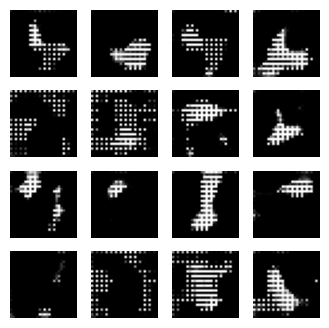

1/1 [==============================] - 0s 28ms/step


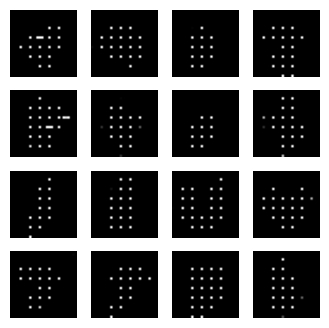

1/1 [==============================] - 0s 18ms/step


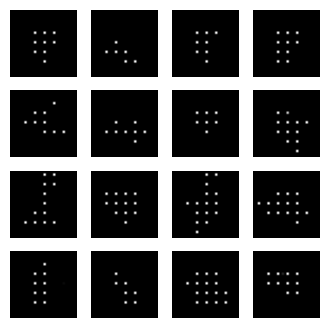

1/1 [==============================] - 0s 19ms/step


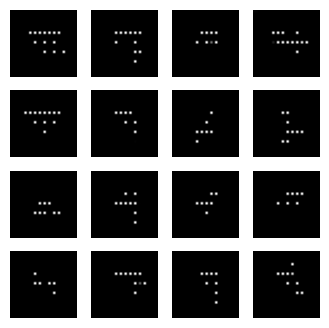

1/1 [==============================] - 0s 17ms/step


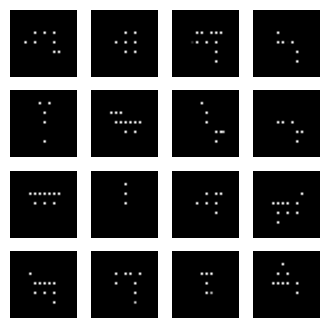

1/1 [==============================] - 0s 16ms/step


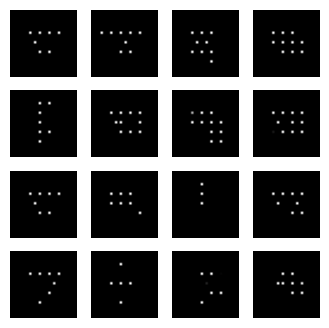

1/1 [==============================] - 0s 25ms/step


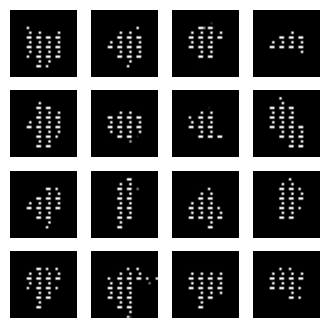

1/1 [==============================] - 0s 18ms/step


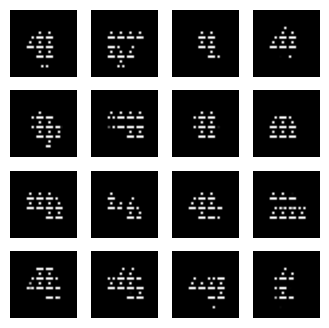

1/1 [==============================] - 0s 16ms/step


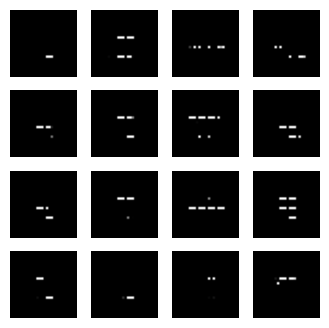

1/1 [==============================] - 0s 27ms/step


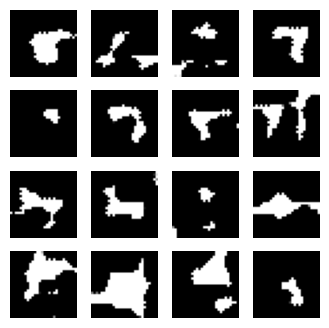

1/1 [==============================] - 0s 21ms/step


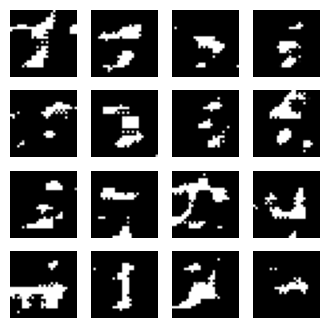

1/1 [==============================] - 0s 18ms/step


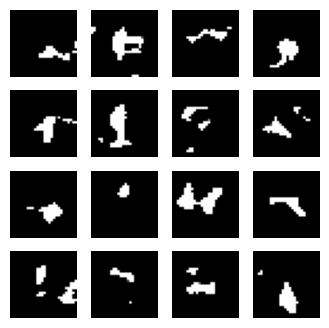

1/1 [==============================] - 0s 17ms/step


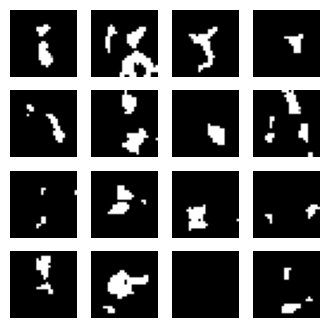

1/1 [==============================] - 0s 19ms/step


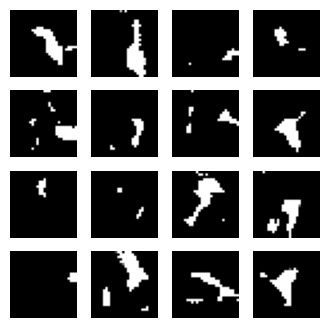

1/1 [==============================] - 0s 16ms/step


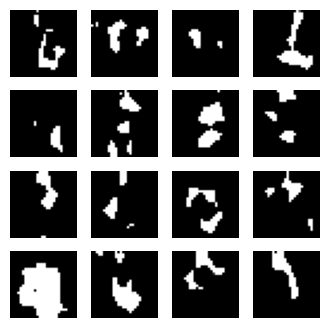

1/1 [==============================] - 0s 27ms/step


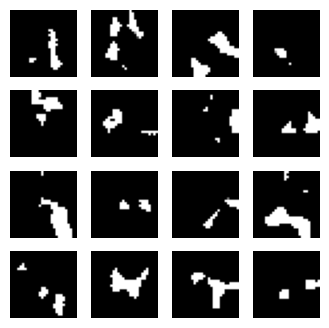

1/1 [==============================] - 0s 16ms/step


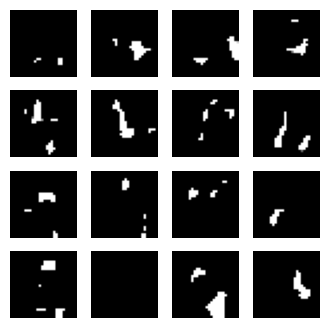

1/1 [==============================] - 0s 18ms/step


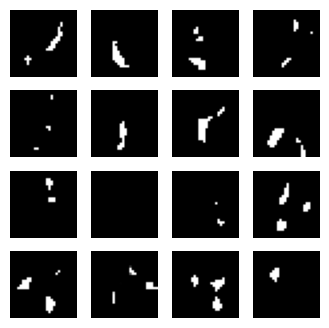

1/1 [==============================] - 0s 24ms/step


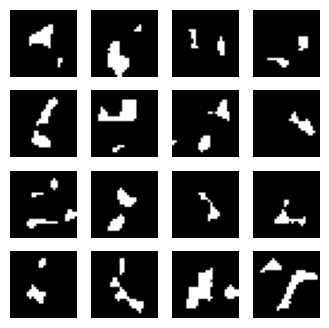

1/1 [==============================] - 0s 18ms/step


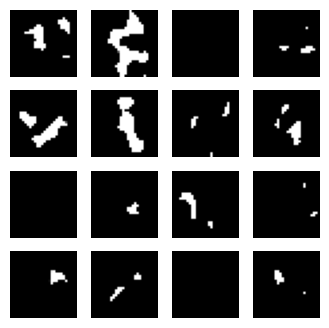

1/1 [==============================] - 0s 17ms/step


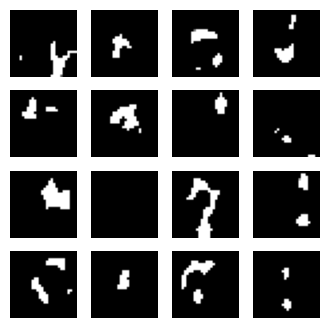

1/1 [==============================] - 0s 25ms/step


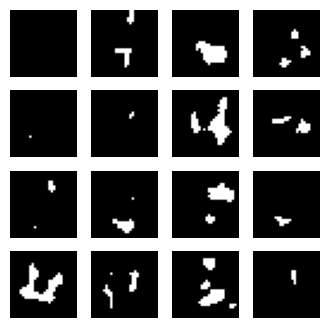

1/1 [==============================] - 0s 26ms/step


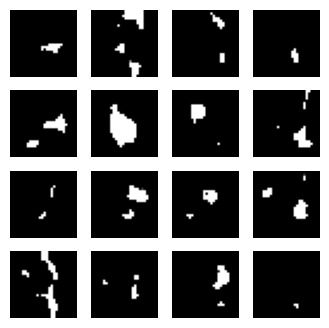

1/1 [==============================] - 0s 19ms/step


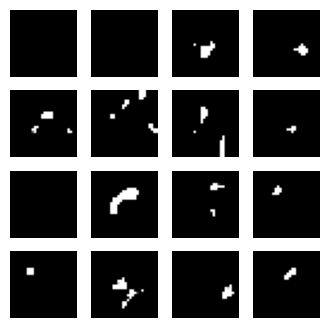

1/1 [==============================] - 0s 25ms/step


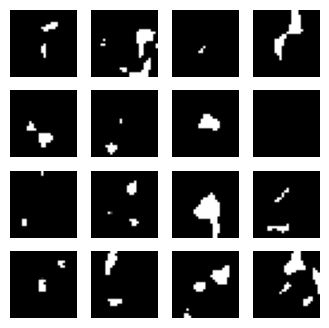

1/1 [==============================] - 0s 17ms/step


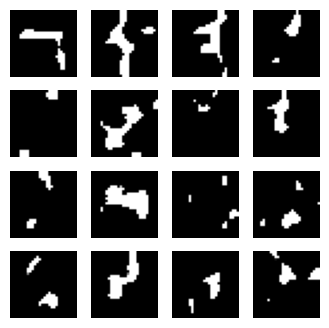

1/1 [==============================] - 0s 30ms/step


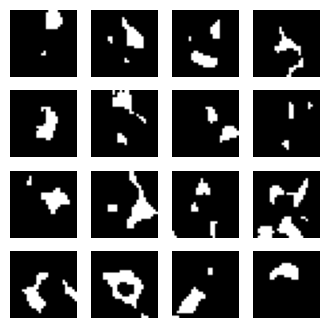

1/1 [==============================] - 0s 23ms/step


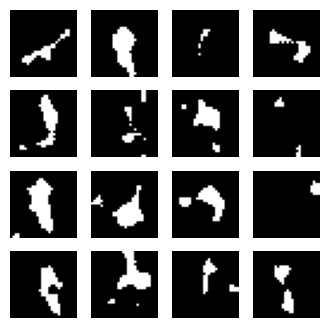

1/1 [==============================] - 0s 18ms/step


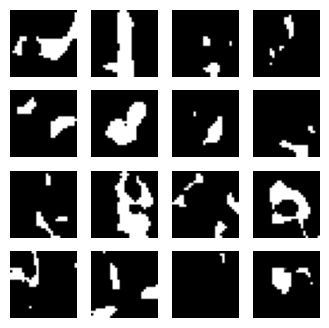

1/1 [==============================] - 0s 17ms/step


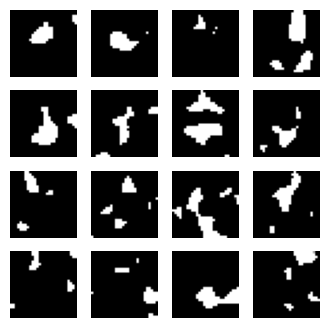

1/1 [==============================] - 0s 16ms/step


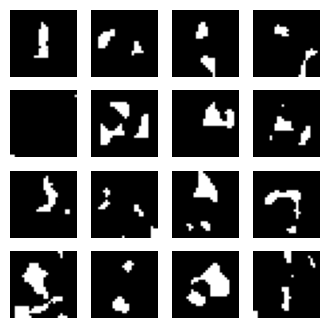

1/1 [==============================] - 0s 23ms/step


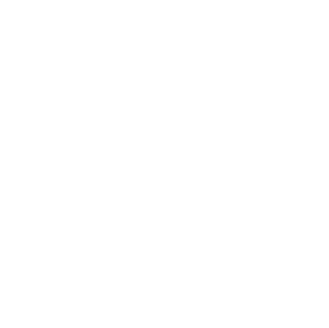

1/1 [==============================] - 0s 18ms/step


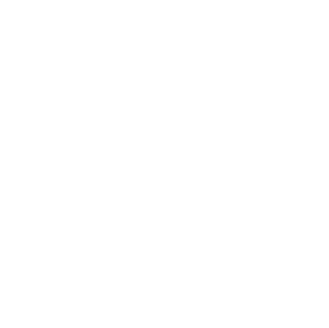

1/1 [==============================] - 0s 28ms/step


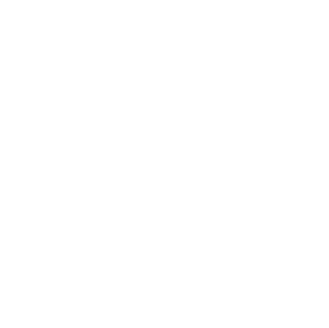

1/1 [==============================] - 0s 17ms/step


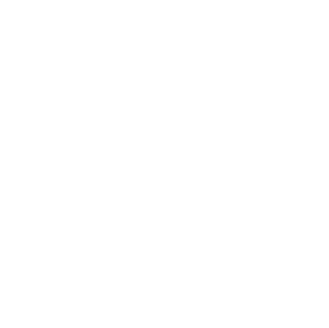

1/1 [==============================] - 0s 25ms/step


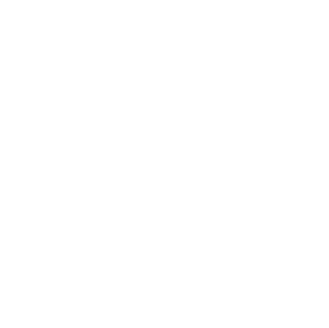

1/1 [==============================] - 0s 21ms/step


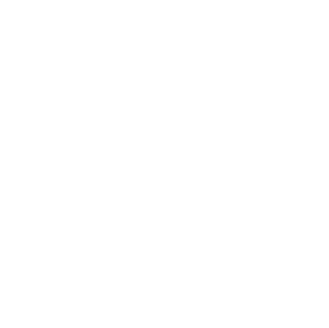

1/1 [==============================] - 0s 16ms/step


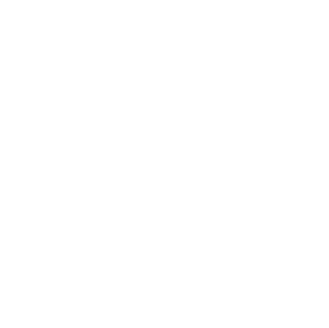

1/1 [==============================] - 0s 16ms/step


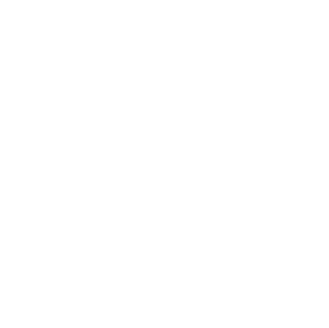

1/1 [==============================] - 0s 24ms/step


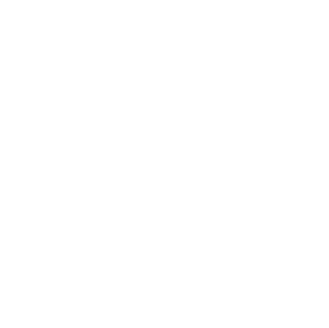

313/313 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.0980
Test Accuracy: 9.80%


In [ ]:
#%matplotlib inline
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Activation, LeakyReLU, Conv2D, Conv2DTranspose, Input, Lambda
#from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.datasets import mnist
import numpy as np
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt


class SSGAN:
    def __init__(self, image_rows, image_columns, image_channels, z_dim, batch_size, epochs, number_of_classes, number_of_labeled):
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.images_rows = image_rows
        self.image_columns = image_columns
        self.image_channels = image_channels
        self.build_discriminator()
        self.build_generator()
        #self.build_adversarial()
        self.losses = []
        self.number_of_classes = number_of_classes
        self.num_labeled = number_of_labeled
    #builds the discriminator architecture that is common for the binary and class classification
    def build_discriminator(self):
        x = Input(shape=(self.images_rows,self.image_columns,self.image_channels))
        discriminator_input=x
        x = Conv2D(32, kernel_size=3, strides=2,padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(64, kernel_size=3, strides=2,padding='same')(x)
        #x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, kernel_size=3, strides=2,padding='same')(x)
        # = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Flatten()(x)
        discriminator_output = Dense(10)(x)
        self.discriminator = Model(discriminator_input, discriminator_output)
        #self.discriminator.compile(optimizer='adam', loss="binary_crossentropy")
    #BUILDS the supervised discriminator
    def build_discriminator_supervised(self, discriminator_net):
        model = Sequential()
        model.add(discriminator_net)
        model.add(Activation('softmax'))
        return model
    #builds the unsupervised descriminator
    def build_discriminator_unsupervised(self, discriminator_net):
        model = Sequential()
        model.add(discriminator_net)
        #i should try to just connect a sigmoid layer with 1 neuron for binary classification
        def predict(x):
            prediction = 1.0 - (1.0 /
            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
            return prediction
        model.add(Lambda(predict))
        return model

    def build_generator(self):
        x = Input(shape=self.z_dim)
        generator_input = x
        x = Dense(256*7*7)(x)
        x = Reshape((7,7,256))(x)
        x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
        #x = BatchNormalization()(x)
        x= LeakyReLU(alpha=0.1)(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(x)
        #x = BatchNormalization()(x)
        x= LeakyReLU(alpha=0.1)(x)
        x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)
        generator_output = Activation('tanh')(x)
        self.generator = Model(generator_input, generator_output)

    def build_adversarial(self):
        self.discriminator_unsupervised.trainable = False
        gan_input = Input(shape=self.z_dim)
        generated_image = self.generator(gan_input)
        gan_output = self.discriminator_unsupervised(generated_image)
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(optimizer=Adam(), loss="binary_crossentropy")

    def train_discriminator_unsupervised(self, real_images, fake_images):
        valid_labels = np.ones((real_images.shape[0],1))
        fake_labels = np.zeros((fake_images.shape[0],1))
        valid_loss = self.discriminator_unsupervised.train_on_batch(real_images, valid_labels)
        fake_loss = self.discriminator_unsupervised.train_on_batch(fake_images, fake_labels)
        return 0.5*fake_loss + 0.5*valid_loss

    def train_discriminator_supervised(self):
        imgs, labels = self.batch_labeled()
        labels = to_categorical(labels, num_classes=self.number_of_classes)
        d_loss_supervised, accuracy = self.discriminator_supervised.train_on_batch(imgs, labels)
        return d_loss_supervised, accuracy


    def train_generator(self, noise):
        generated_labels = np.ones((noise.shape[0],1))
        self.gan.train_on_batch(noise, generated_labels)

    def load_mnist(self):
        (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
        train_images.reshape(-1, 28, 28, 1).astype('float32')
        train_images =  (train_images.astype(np.float32) - 127.5) / 127.5  # Normalize the images to [-1, 1]
        test_images.reshape(-1, 28, 28, 1).astype('float32')
        test_images ==  (test_images.astype(np.float32) - 127.5) / 127.5
        return train_images, train_labels, test_images, test_labels
    #returns labeled images to be used in labeled classification
    def batch_labeled(self):
        idx = np.random.randint(0, self.num_labeled, self.batch_size)
        imgs = self.train_images[idx]
        labels = self.train_labels[idx]
        return imgs, labels
    #return unlabeled images to be used in binary classification real/not
    def batch_unlabeled(self):
        idx = np.random.randint(self.num_labeled, self.train_images.shape[0], self.batch_size)
        imgs = self.train_images[idx]
        return imgs

    def train_gan(self, sample_interval=200):
        self.train_images,self.train_labels,self.test_images,self.test_labels = self.load_mnist()
        self.discriminator_supervised = self.build_discriminator_supervised(self.discriminator)
        self.discriminator_supervised.compile(loss='categorical_crossentropy',
        metrics=['accuracy'],
        optimizer=Adam())
        self.discriminator_unsupervised = self.build_discriminator_unsupervised(
        self.discriminator)
        self.discriminator_unsupervised.compile(loss='binary_crossentropy',
        optimizer=Adam())
        self.build_adversarial()
        for epoch in range(self.epochs):
            noise = np.random.normal(0, 1, (self.batch_size, self.z_dim))
            idx = np.random.randint(0,self.train_images.shape[0], self.batch_size)
            real_images = self.batch_unlabeled()
            fake_images = self.generator.predict(noise)
            self.train_discriminator_unsupervised(real_images, fake_images)
            self.train_discriminator_supervised()
            noise = np.random.normal(0, 1, (self.batch_size, self.z_dim))
            self.train_generator(noise)
            if (epoch + 1) % sample_interval == 0:

                # Save losses and accuracies so they can be plotted after training
                #losses.append((d_loss, g_loss))
                #accuracies.append(100.0 * accuracy)
                #iteration_checkpoints.append(iteration + 1)

                # Output training progress
                #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                #    (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

                # Output a sample of generated image
                self.sample_images()


    def sample_images(self, image_grid_rows=4, image_grid_columns=4):

        # Sample random noise
        z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, self.z_dim))

        # Generate images from random noise
        gen_imgs = self.generator.predict(z)

        # Rescale image pixel values to [0, 1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Set image grid
        fig, axs = plt.subplots(image_grid_rows,
                                image_grid_columns,
                                figsize=(4, 4),
                                sharey=True,
                                sharex=True)

        cnt = 0
        for i in range(image_grid_rows):
            for j in range(image_grid_columns):
                # Output a grid of images
                axs[i, j].imshow(gen_imgs[cnt,:,:,:], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

if __name__ == "__main__":
    BATCH_SIZE = 32
    EPOCHS = 8000
    NUMBER_OF_CLASSES = 10
    NUMBER_OF_LABELED = 100
    GAN = SSGAN(image_rows=28, image_columns=28, image_channels=1, z_dim=100, batch_size=BATCH_SIZE, epochs=EPOCHS, number_of_classes=NUMBER_OF_CLASSES, number_of_labeled=NUMBER_OF_LABELED)
    GAN.train_gan()
    _,_,x, y = GAN.load_mnist()
    y = to_categorical(y, num_classes=NUMBER_OF_CLASSES)
    _, accuracy = GAN.discriminator_supervised.evaluate(x, y)
    print("Test Accuracy: %.2f%%" % (100 * accuracy))

In [ ]:
x_train,y_train,x, y = GAN.load_mnist()
y_train = to_categorical(y_train, num_classes=NUMBER_OF_CLASSES)
y = to_categorical(y, num_classes=NUMBER_OF_CLASSES)
_, accuracy = GAN.discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))
_, accuracy2 = GAN.discriminator_supervised.evaluate(x_train, y_train)
print("Train Accuracy: %.2f%%" % (100 * accuracy2))


313/313 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0980
Test Accuracy: 9.80%
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.0987
Train Accuracy: 9.87%
